In [1]:
import sys
# sys.path.append('/Users/tport/Desktop/USC/Semesters/Projects/LSP/sllsp')
sys.path.append('/Users/tport/miniconda3/envs/RL-LSP/lib/python3.13/site-packages')

## Gymnasium code
Gymnasium code for reference, which is much easier to read and has better documentation.

In [ ]:
"""
Copied from https://gymnasium.farama.org/introduction/record_agent/
"""

import logging

import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

logging.basicConfig(level=logging.INFO)

training_period = 250  # record the agent's episode every 250
num_training_episodes = 100  # total number of training episodes

env = gym.make("CartPole-v1", render_mode="rgb_array")  # replace with your environment
# env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="training",
#                   episode_trigger=lambda x: x % training_period == 0)
env = RecordEpisodeStatistics(env)

for episode_num in range(num_training_episodes):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated

    print(f"episode-{episode_num}", info["episode"])
env.close()

## Playing with the environment
Use the basic APIs `step_env`, `action_space`, `sample` to interact with a dumb agent, which uniformly at random picks gates from the available set.

In [ ]:
from gymnax.environments import environment
from simulators.clifford_gates import CliffordGates
from envs.logical_state_preparation_env import LogicalStatePreparationEnv
import jax
import time

class DumbAgent:
    def __init__(self, env : environment.Environment) -> None:
        self.env = env;
        pass

    def action(self, rng_key, state):
        return self.env.action_space().sample(rng_key);

key = jax.random.key(int(time.time()))
key, key_reset, key_act, key_step = jax.random.split(key, 4)

n = 2;
target = ["+ZI", "+IZ"];
# target = ["+ZZZZZZZ", "+ZIZIZIZ", "+XIXIXIX", "+IZZIIZZ", "+IXXIIXX", "+IIIZZZZ", "+IIIXXXX"];
clifford_gates = CliffordGates(n);

lsp = LogicalStatePreparationEnv(
    target,
    gates=[clifford_gates.s, clifford_gates.sqrt_x],
    graph=None,
    distance_metric = 'jaccard',
    max_steps = 5,
    threshold = 0.99,                     
)
env_params = None;

agent = DumbAgent(lsp);

observation, env_state = lsp.reset_env(key_reset, env_params);
done = False;
counter = 0;
total_reward = 0;
# action_list = [2, 1, 2, 2, 2];
while not done:
    key_act, _rng = jax.random.split(key_act);
    action = agent.action(key_act, observation);
    # action = action_list[counter];
    key_step, _rng = jax.random.split(key_step);
    next_observation, env_state, reward, done, info = lsp.step_env(key_step, env_state, action, env_params)
    # next_observation, reward, terminated, truncated, info = lsp.step_env();
    observation = next_observation;
    counter += 1;
    total_reward += reward;
    print(f"Gate: ({action}) {lsp.action_string_stim_circ[action]}\nReward: {reward}, Add. info: {info}\nDone?: {done}")
    print()
print(counter, total_reward)

# Serious code
## Imports

In [1]:
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch

import time
import numpy as np
import jax

from gymnax.environments import environment
from simulators.clifford_gates import CliffordGates
from envs.logical_state_preparation_env import LogicalStatePreparationEnv


In [2]:
import time
import functools

def timeit(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        print(f"{func.__name__} took {end_time - start_time:.4f} seconds")
        return result
    return wrapper


## Interacting with the environment

In [78]:
# %load_ext autoreload
# %autoreload 2
# from training.dataset import generate_training_data_for_given_params
import pickle

from models.input import GT_1Q, GT_2Q, Layout, sample_layout
from envs.logical_state_preparation_env import LogicalStatePreparationEnv
from simulators.clifford_gates import CliffordGates
from training.dataset import TrainingInstance, sample_gate_set, create_lsp_env

time_tracker = [[], [], [], []]

def generate_training_data_for_given_params(
    n: int,
    jax_rng_key: jax.Array,
    gen: torch.Generator | None = None,
) -> tuple[TrainingInstance, jax.Array]:
    """Given `n` = # qubits, generate a circuit of n qubits with a random topology
    and random gate set, with depth = `depth`.
    Args:
        n
        keys: Tuple of 4 RNGs for jax
        gen: torch.Generator
    """
    tic = time.time()
    key, key_reset, key_act, key_step = jax.random.split(jax_rng_key, 4)

    layout = sample_layout(n, gen)
    gate_set_1q, gate_set_2q = sample_gate_set(gen)

    if len(gate_set_1q) + len(gate_set_2q) < 2:
        d_max = 3
    else:
        d_max = np.floor(
            n * n / np.log2(len(gate_set_1q) + len(gate_set_2q)),
            casting="unsafe",
            dtype=np.int32,
        )
    depth = (
        torch.randint(low=1, high=d_max, size=(1,), generator=gen)[0]
        if d_max > 1
        else torch.tensor(1)
    )
    depth = depth.item()
    print(f"GT 1Q: {gate_set_1q}, GT 2Q: {gate_set_2q}, n: {n}, d: {depth}, max depth: {d_max}")
    toc = time.time()
    time_tracker[0].append(toc-tic)

    tic = time.time()
    lsp_env = create_lsp_env(layout, gate_set_1q, gate_set_2q, depth)
    toc = time.time()
    time_tracker[1].append(toc-tic)

    tic = time.time()
    env_params = None
    _observation, env_state = lsp_env.reset_env(key_reset, env_params)
    assert (
        _observation.shape[-1] == 2 * n * n + n
    ), f"""Implementation (e.g. StabilizerEncoding) depends on the shape
    of the observation being 2 * n * n + n (all stabilizers, followed by n signs). Received {_observation.shape}
    instead"""

    gate_list = []
    for _ in range(depth):
        key_act, _rng = jax.random.split(key_act)
        gate_list.append(lsp_env.action_space(env_params).sample(key_act))

        key_step, _rng = jax.random.split(key_step)
        observation, env_state, _reward, _done, _info = lsp_env.step_env(
            key_step, env_state, gate_list[-1], env_params
        )
    observation = torch.from_dlpack(observation).long()
    toc = time.time()
    time_tracker[2].append(toc-tic)
    time_tracker[3].append((toc-tic)/depth)
    return (
        TrainingInstance(
            n, layout, gate_set_1q, gate_set_2q, depth, gate_list, observation, lsp_env
        ),
        key,
    )

@timeit
def generate_training_data(N: int, jax_rng_key: jax.Array, gen: torch.Generator) -> None:
    batch = []
    batch_size = 10_000
    batch_count = 0
    n_min, n_max = 2, 20
    generated_set = set()
    for _i in range(N):
        n = torch.randint(low=n_min, high=n_max, size=(1,), generator=gen)[0]
        n = n.int().item()
        instance, jax_rng_key = generate_training_data_for_given_params(n, jax_rng_key, gen)
        if hash(instance) in generated_set:
            continue
        generated_set.add(hash(instance))
        batch.append(instance)
        if len(batch) == batch_size:
            with open(f'training-data/{batch_count}.pkl', 'wb') as f:
                pickle.dump(batch, f)
                batch = []
                batch_count += 1
    if len(batch) > 0:
        with open(f'training-data/{batch_count}.pkl', 'wb') as f:
            pickle.dump(batch, f)
            batch = []
            batch_count += 1


In [79]:
seed = 1#time.time_ns()

# JAX RNG
key = jax.random.key(seed)

# Torch RNG
gen = torch.Generator()
gen.manual_seed(seed)

generate_training_data(100, key, gen)
        

GT 1Q: [<GT_1Q.X: 3>], GT 2Q: [<GT_2Q.CZ: 2>], n: 15, d: 151, max depth: 225


/Users/tport/miniconda3/envs/RL-LSP/lib/python3.13/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/tport/miniconda3/envs/RL-LSP/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


GT 1Q: [<GT_1Q.X: 3>], GT 2Q: [], n: 12, d: 2, max depth: 3
GT 1Q: [<GT_1Q.H: 1>, <GT_1Q.S: 2>, <GT_1Q.SQRT_X: 4>], GT 2Q: [<GT_2Q.CZ: 2>], n: 2, d: 1, max depth: 2
GT 1Q: [<GT_1Q.S: 2>, <GT_1Q.X: 3>, <GT_1Q.SQRT_X: 4>], GT 2Q: [<GT_2Q.CX: 1>], n: 8, d: 15, max depth: 32
GT 1Q: [<GT_1Q.X: 3>], GT 2Q: [], n: 2, d: 2, max depth: 3
GT 1Q: [<GT_1Q.H: 1>, <GT_1Q.S: 2>], GT 2Q: [<GT_2Q.CX: 1>, <GT_2Q.CZ: 2>], n: 6, d: 4, max depth: 18
GT 1Q: [<GT_1Q.S: 2>, <GT_1Q.X: 3>], GT 2Q: [], n: 3, d: 3, max depth: 9
GT 1Q: [<GT_1Q.H: 1>, <GT_1Q.S: 2>, <GT_1Q.X: 3>], GT 2Q: [<GT_2Q.CX: 1>], n: 10, d: 26, max depth: 50
GT 1Q: [<GT_1Q.X: 3>, <GT_1Q.SQRT_X: 4>], GT 2Q: [<GT_2Q.CZ: 2>], n: 8, d: 22, max depth: 40
GT 1Q: [<GT_1Q.H: 1>], GT 2Q: [], n: 10, d: 2, max depth: 3
GT 1Q: [<GT_1Q.H: 1>, <GT_1Q.SQRT_X: 4>], GT 2Q: [<GT_2Q.CZ: 2>], n: 3, d: 3, max depth: 5
GT 1Q: [<GT_1Q.X: 3>, <GT_1Q.SQRT_X: 4>], GT 2Q: [<GT_2Q.CX: 1>], n: 19, d: 61, max depth: 227
GT 1Q: [<GT_1Q.H: 1>], GT 2Q: [], n: 12, d: 1, max d

In [80]:
from training.dataset import TrainingInstance

with open(f'training-data/0.pkl', 'rb') as f:
    loaded_objects = pickle.load(f)
training_instances : list[TrainingInstance] = loaded_objects

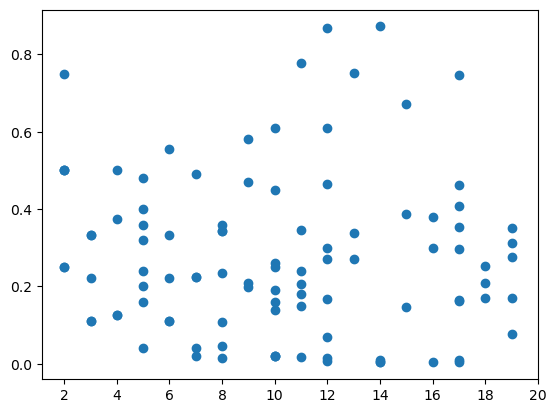

In [81]:
import matplotlib.pyplot as plt

n = np.array([x.n for x in training_instances])
d = np.array([x.circuit_depth for x in training_instances])
plt.scatter(n, d / (n*n))
n = np.linspace(2, 20, 100)
# plt.plot(n, n*n, c='r')
plt.xticks([2*i for i in range(1,11)])
plt.show()

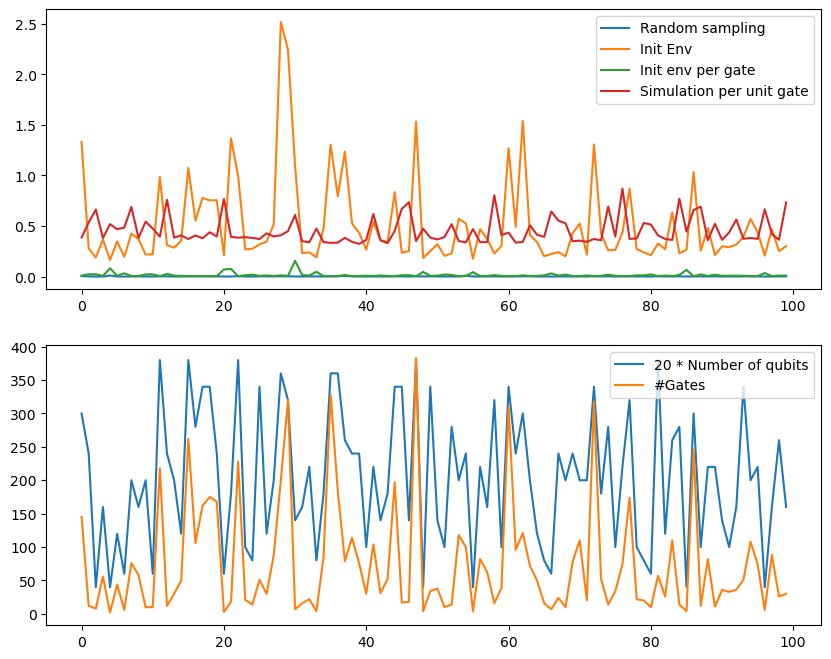

In [89]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(time_tracker[0], label="Random sampling")
ax1.plot(time_tracker[1], label="Init Env")
ax1.plot([time_tracker[1][i]/training_instances[i].env.action_space().n for i in range(len(training_instances))], label="Init env per gate")
# ax1.plot(time_tracker[2], label="Simulation")
ax1.plot(time_tracker[3], label="Simulation per unit gate")
ax1.legend()

ax2.plot(np.array([20 * x.n for x in training_instances]), label="20 * Number of qubits")
# ax2.plot(np.array([x.circuit_depth for x in training_instances]), label="Depth")
ax2.plot(np.array([x.env.action_space().n for x in training_instances]), label="#Gates")
ax2.legend()
plt.show()

In [90]:
init_per_gate_time = np.array([time_tracker[1][i]/training_instances[i].env.action_space().n for i in range(len(training_instances))])
print("Initialization time statistics:")
print(f"Mean: {np.mean(init_per_gate_time)} s")
print(f"Median: {np.median(init_per_gate_time)} s")
print(f"Std: {np.std(init_per_gate_time)}")

print()

sim_per_gate_time = np.array(time_tracker[3])
print("Simulation time statistics:")
print(f"Mean: {np.mean(sim_per_gate_time)} s")
print(f"Median: {np.median(sim_per_gate_time)} s")
print(f"Std: {np.std(sim_per_gate_time)}")

Initialization time statistics:
Mean: 0.015475194045107141 s
Median: 0.008367732080102663 s
Std: 0.020775838454848743

Simulation time statistics:
Mean: 0.4569150567231596 s
Median: 0.3961619395348761 s
Std: 0.12992195307218748


In [91]:
def predict_time(N):
    # Assume mean init time per gate = 0.015s
    # and mean sim time per gate = 0.457s
    ts, ti = 0.015, 0.457
    return ((N+1)*(2*N+1)/12+0.5) * ts + ((N+1)*(2*N+1)/24 + (N+1) * (1/8+1)) * ti
predict_time(20)

28.27525

In [77]:
time_tracker

[[0.002863645553588867,
  0.000827789306640625,
  0.000492095947265625,
  0.0010228157043457031,
  0.001255035400390625,
  0.0011219978332519531,
  0.0008549690246582031,
  0.0008308887481689453,
  0.0005998611450195312,
  0.0015549659729003906,
  0.0006849765777587891,
  0.0006330013275146484,
  0.0015101432800292969,
  0.0005021095275878906,
  0.0008740425109863281,
  0.0005469322204589844,
  0.0005199909210205078,
  0.0008170604705810547,
  0.0006520748138427734,
  0.0006928443908691406,
  0.0014939308166503906,
  0.0007429122924804688,
  0.0006880760192871094,
  0.0006918907165527344,
  0.0007290840148925781,
  0.0006227493286132812,
  0.0006799697875976562,
  0.0008461475372314453,
  0.0009047985076904297,
  0.001420736312866211,
  0.0007748603820800781,
  0.0016260147094726562,
  0.0006537437438964844,
  0.0005769729614257812,
  0.0014331340789794922,
  0.0014948844909667969,
  0.0007088184356689453,
  0.001402139663696289,
  0.0007328987121582031,
  0.001293182373046875,
  0.000

In [5]:
import numpy as np
import time
import torch.optim as optim

from models.model_v0 import ModelV0

seed = time.time_ns()

# JAX RNG
key = jax.random.key(seed)
key, key_reset, key_act, key_step = jax.random.split(key, 4)

# Torch RNG
gen = torch.Generator()
gen.manual_seed(seed)

n_min, n_max = 2, 5
eigval_trunc_dim = 10  # Size of the truncated eigenvalue list of the Graph laplacian
eigvec_trunc_dim = 20  # Size of each truncated eigenvector of the Graph laplacian
# Qubit tensor dimension is therefore 40. Then, 2 qubit gate types require 80 dimensions
# and 1 qubit dimension
gt_1q_dim = 80
gt_2q_dim = 80
stab_sign_dim = 8
pauli_dim = 40
hetero_attention_embed_dim = 100

sl_model = ModelV0(
    eigval_trunc_dim,
    eigvec_trunc_dim,
    gt_1q_dim,
    gt_2q_dim,
    stab_sign_dim,
    pauli_dim,
    hetero_attention_embed_dim=hetero_attention_embed_dim,
)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(sl_model.parameters())
loss_history = []
tic = time.time()
count = 0

for i in range(10000):
    toc = time.time()
    if toc - tic > 30:
        break
    if i % 100 == 0:
        print(f"Iteration {i}:")
        if len(loss_history) > 0:
            print(f"  Last loss: {loss_history[-1]:.6f}")
            print(f"  Avg loss (last 100): {np.mean(loss_history[-100:]):.6f}")
        else:
            print("  No loss recorded yet.")

    training_data = create_labelled_data(n_min, n_max, gen)
    gate_prediction, depth_prediction = sl_model.forward(
        training_data.layout,
        training_data.gate_set_1q,
        training_data.gate_set_2q,
        training_data.observation,
    )

    optimizer.zero_grad()
    correct_answer = torch.tensor(
        [torch.from_dlpack(training_data.applied_gates[-1]).long()]
    )
    # output = loss(gate_prediction, torch.tensor(correct_answer).float())
    output = loss(gate_prediction.unsqueeze(0), correct_answer)
    loss_history.append(output.detach().item())

    output.backward()
    optimizer.step()
    count += 1

toc = time.time()
print(f"{toc-tic} s for {count} iterations")

Iteration 0:
  No loss recorded yet.


/Users/tport/miniconda3/envs/RL-LSP/lib/python3.13/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint8 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/tport/miniconda3/envs/RL-LSP/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


30.813631057739258 s for 29 iterations


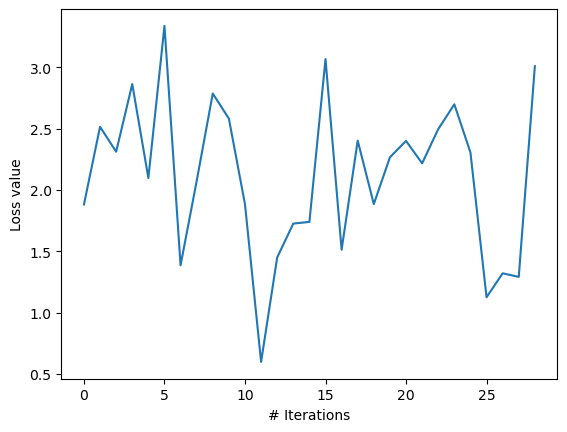

In [6]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("# Iterations")
plt.ylabel("Loss value")
plt.show()

## Dry Run

In [7]:
embedding_dims = TokenProperties(
            eigval_trunc_dim,
            eigvec_trunc_dim,
            gt_1q_dim,
            gt_2q_dim,
            stab_sign_dim,
            pauli_dim
        )
token_A_embedding = Token_A_Embedding(embedding_dims)
token_B_embedding = Token_B_Embedding(embedding_dims)
token_C_embedding = Token_C_Embedding(embedding_dims)
token_D_embedding = Token_D_Embedding(embedding_dims)
token_E_embedding = Token_E_Embedding(embedding_dims)

n = 5
loss = nn.MSELoss()
optimizer = optim.Adam(token_C_embedding.parameters())

for i in range(2):
    n, layout, gate_set_1q, gate_set_2q, d, gate_list, observation, lsp_env = create_labelled_data(n, n+1, gen)

    graph_eigval, graph_eigvec = torch.linalg.eigh(layout.graph.float())
    target = torch.randn(embedding_dims.dA).unsqueeze(0)

    optimizer.zero_grad()

    ##### Computation #####
    graph_eigval, graph_eigvec = torch.linalg.eigh(layout.graph.float())
    # Token A -> Global token representing the graph
    global_tensor = token_A_embedding(graph_eigval)
    # Token B
    # Q: Is there no learned embedding for the qubits? It will be used in stabilizer and
    # tableau-cell tokens as well. There seems to be a very small amount of learnable
    # components then.
    qubit_tensors = token_B_embedding(graph_eigvec)
    nq = qubit_tensors.shape[-2]
    # Token C
    gate_tensors = token_C_embedding(gate_set_1q, gate_set_2q, qubit_tensors, layout)
    print(observation.shape)
    # Token D
    stabilizer_tensors = token_D_embedding(nq, observation)
    # Token E
    tableau_cell_tensors = token_E_embedding(qubit_tensors, observation)
    ######   #####

    target = torch.randn(*gate_tensors.shape[-2:])
    output = loss(target, gate_tensors)
    output.backward()
    optimizer.step()


NameError: name 'TokenProperties' is not defined

In [ ]:
import torch.optim as optim

# create your optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(sl_model.parameters())
optimizer.zero_grad()
correct_answer = [0 for _ in range(lsp_env.action_space(env_params).n)]
correct_answer[gate_list[-1]] = 1
output = loss(Token_A_Embedding, torch.tensor(correct_answer).float())
output.backward()
optimizer.step()

NameError: name 'env_params' is not defined